# Fanal, a neutrino-less beta decay search 

## An open exercise

### Signal selection 

#### USC, Master de Física, Física de Partícula II


J. A. Hernando-Morata, 
with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro, G. Díaz.

February 2021


In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD Your Fanal FOLDER TO PYTHONPATH
import os
import sys
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal


In [4]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import ana.collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Objectice

**Define** a selection or **an analysis strategy** to better identify bb0nu events and discard background events using simulated data.

### Tasks:

   * open the data file (HDF) and access the simulation data (MC) for the main backgrounds: 214Bi and 208Tl, and the bb0nu signal.

   * Inspect the variables. Identify the most powerful variables.
   
   * Replicate the 'fanal' analysis (see bellow).

   * Define a selection (a list of cuts) and compare it with the 'fanal' analysis.
   
      * You can also try a Multi-Variate methods, but it is not necessary.
      
   * Estimate the energy resolution at the Qbb value.
   
 ### Notes:
 
 
   * The variable 'mcE' is the true energy, it is not measurable, and therefore it can not be used in any analysis!
   
   * The rest of the varaibles are the 'measurable' quantities and can be used in the analysis.

## Main parameters

In [5]:
coll   = 'test_alpha'
erange = fn.erange
eroi   = fn.eroi 
eblob2 = fn.eblob2

print('Data From               : {:s}'.format(coll))
print('Energy range            : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Blob-2 energy threshold : {:6.3f} MeV'.format(eblob2))
print('Energy RoI range        : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Data From               : test_alpha
Energy range            : ( 2.400,  2.700) MeV
Blob-2 energy threshold :  0.400 MeV
Energy RoI range        : ( 2.430,  2.480) MeV


## Access the data

In [6]:
dirpath = '/Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/'
filename = 'fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/fanal_test_alpha.h5


## inspect the variables



In [7]:
mcbb

,mcE,E,num_tracks,num_voxels,track0_E,track0_voxels,track0_length,blob1_E,blob2_E,track1_E,track1_voxels,track1_length
0,2.457830,2.471280,1.0,17,2.471280,17.0,32.944061,NaN,NaN,NaN,NaN,NaN
1,1.627345,1.629487,1.0,13,1.629487,13.0,37.781500,0.841852,0.695263,NaN,NaN,NaN
2,2.457830,2.462075,1.0,14,2.462075,14.0,59.881962,0.961564,0.803745,NaN,NaN,NaN
3,2.457830,2.460759,1.0,21,2.460759,21.0,96.354208,1.005637,0.890549,NaN,NaN,NaN
4,2.457830,2.457934,2.0,20,2.428695,19.0,77.856795,NaN,NaN,0.029239,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
59993,2.457830,2.460685,1.0,16,2.460685,16.0,81.789893,1.051982,0.844432,NaN,NaN,NaN
59994,2.457830,2.461850,2.0,21,2.320462,19.0,74.822016,NaN,NaN,0.141387,2.0,17.020782
59996,2.457830,2.453377,1.0,22,2.453377,22.0,72.873822,0.902138,0.473505,NaN,NaN,NaN
59997,2.457830,2.455108,1.0,22,2.455108,22.0,35.444050,NaN,NaN,NaN,NaN,NaN


### Histogram the variables

We are drawing the variables only in the relevant range (2.6, 2.7 MeV)

In [8]:
mcs      = [mcbb, mcbi, mctl] # list of the mc DFs
tsamples = ['bb', 'Bi', 'Tl']
ssamples = [r'$\beta\beta0\nu$', r'$^{214}$Bi', r'$^{208}$Tl'] # str names of the mc samples

In [9]:
# Draw all the variables of the data-frames for the mc samples
def selection(df, varname, varrange):
    """ apply the selection df.varname in a range, varange
    inputs:
        df       : dataFrame
        varname  : str, name of the variable int he DF
        varrange : tuple(float, float), range of the selection, all (-np.inf, np.inf)
    returns:
        sel      : np.array(bool) same same of DF with True/False
                   if the item fulfull variable value (varname) inside the range (varrange)
    """
    sel = (df[varname] >= varrange[0]) & (df[varname] < varrange[1])
    return sel

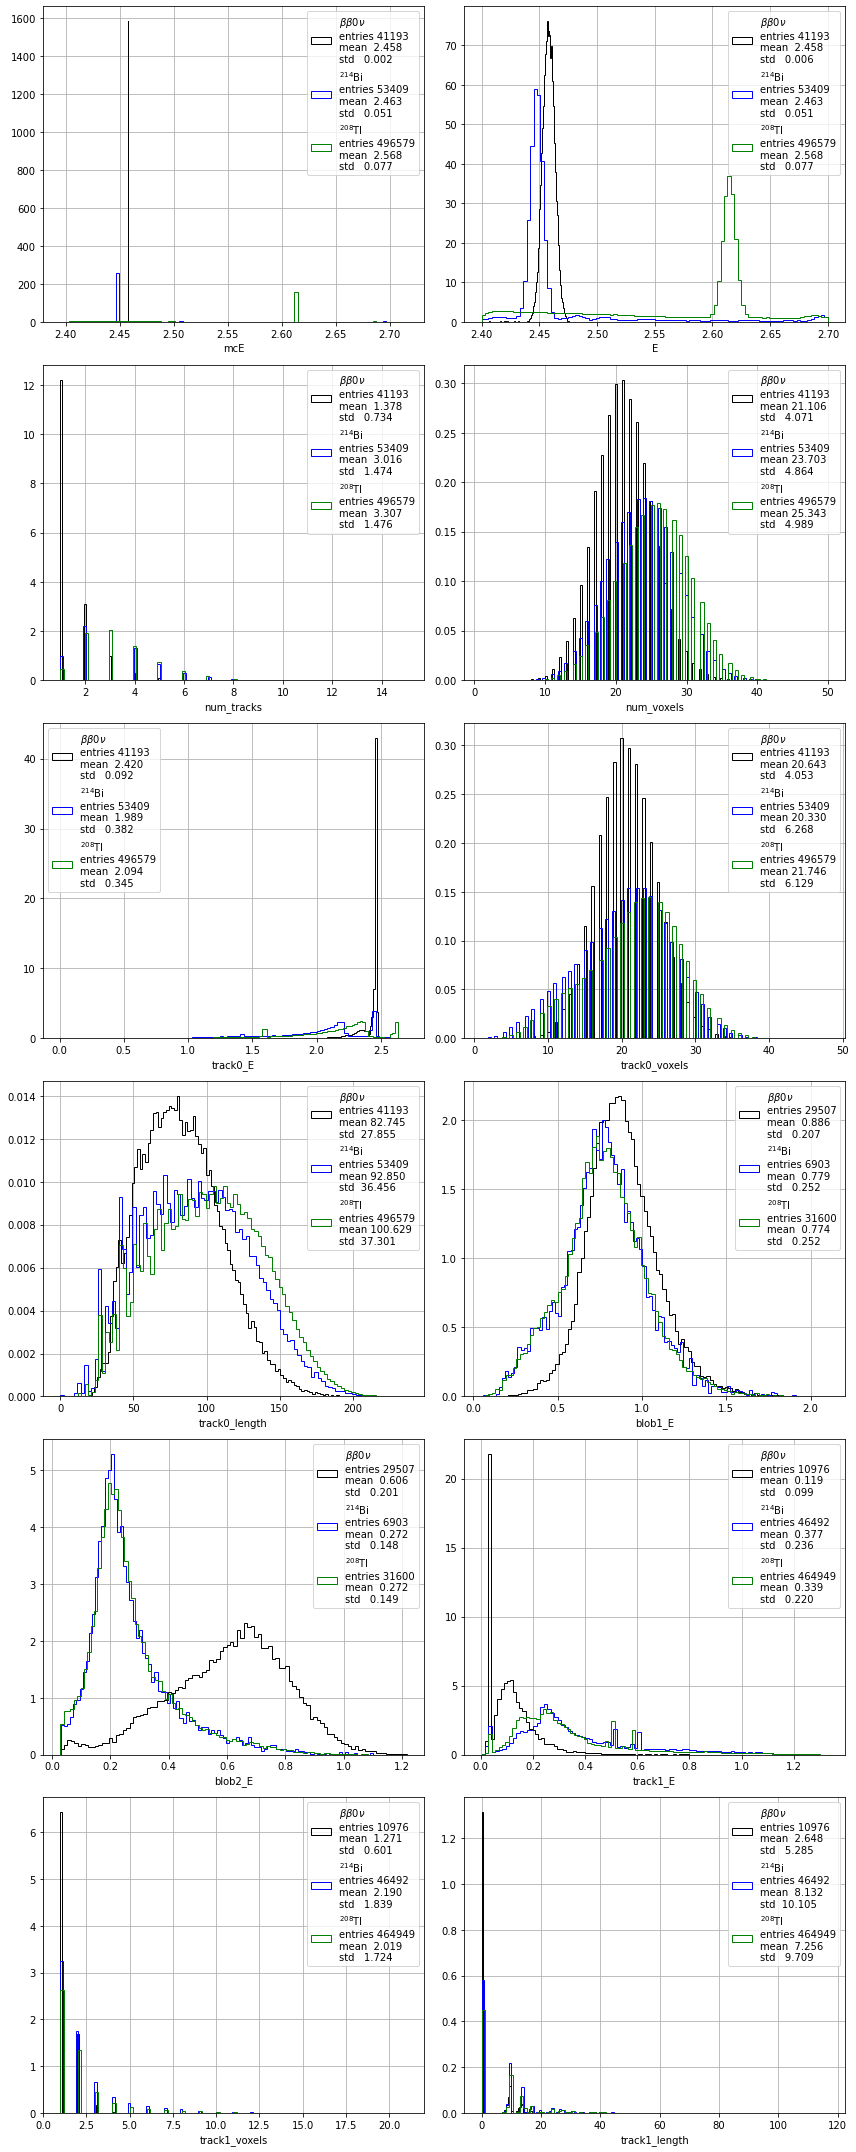

In [10]:
ename = 'E'
# filter the MC DF only consider events with energy in the energy-range
xmcs  = [mc[selection(mc, ename, erange)] for mc in mcs]

# plot the distribution of all the variables
pltext.dfs_inspect(xmcs, dfnames = ssamples, ncolumns = 2)

## Fanal analysis

The analysis is based in selecting a very pure sample of bb0nu. It applies a list of cuts. 

The experiment can be then consider either as a counting experiment (estimate the number of bkg events in the RoI and compare it with the number of observed events)

The 'fanal' selection has the following cuts:

   * Energy of the event is on the *erange* MeV range.
   
   * One reconstructed track. Most of the signal has only 1 track, while the background has in general more than one.
   
   * Second blob energy (the less energetic blob of the track) must have at least *eblob2* keV. The signal has a real blob while the sedond blob of background must be in general the initial part of the electron track and should have smaller energy.
   
   * Region of Interest (RoI). The relevant gaussian region where the bb0nu is. In this example *eroi* MeV
   

### Plot the analysis variables 

Plot the variables of the analysis for the different MC samples.

In [11]:
def plt_fanal_mc(mcs, ssamples, bins = 100, erange = erange, eroi = eroi):
    """ Plot the relevant analysis variables, for the different mc samples
    """

    subplot = pltext.canvas(5)

    subplot(1)
    for i, mc in enumerate(mcs):
        sel = (mc.E >= erange[0]) & (mc.E < erange[1])
        # sel = ut.in_range(mc.E, erange) equivalent using in_range method of utils
        pltext.hist(mc.E[sel], 100, label = ssamples[i], density = True)
        plt.xlabel('Energy (MeV)'); plt.title('E range');
    
    subplot(2)
    for i, mc in enumerate(mcs):
        sel  = ut.in_range(mc.E, erange)
        pltext.hist(mc.num_tracks[sel], 50, label = ssamples[i], density = True, range = (0, 15))
        plt.xlabel('number of tracks'); plt.title('E range')

    subplot(3)
    for i, mc in enumerate(mcs):
        sel  = ut.in_range(mc.E, erange) & mc.num_tracks == 1
        pltext.hist(mc.blob2_E[sel], 100,  label = ssamples[i], density = True)
        plt.xlabel('Energy blob2 (MeV)'); plt.title('E range - 1 track')

    subplot(4)
    for i, mc in enumerate(mcs):
        sel  = (ut.in_range(mc.E, erange)) & (mc.num_tracks == 1) & (mc.blob2_E >= 0.4)
        pltext.hist(mc.E[sel], 100,  label = ssamples[i], density = True)
        plt.xlabel('Energy (MeV)'); plt.title('E range - 1 track - blob2 cut')  
        
    subplot(5)
    for i, mc in enumerate(mcs):
        sel  = (ut.in_range(mc.E, eroi)) & (mc.num_tracks == 1) & (mc.blob2_E >= 0.4)
        pltext.hist(mc.E[sel], 100,  label = ssamples[i], density = True)
        plt.xlabel('Energy  (MeV)'); plt.title('E RoI - 1 track - blob2 cut') 
    
    plt.tight_layout();
    return

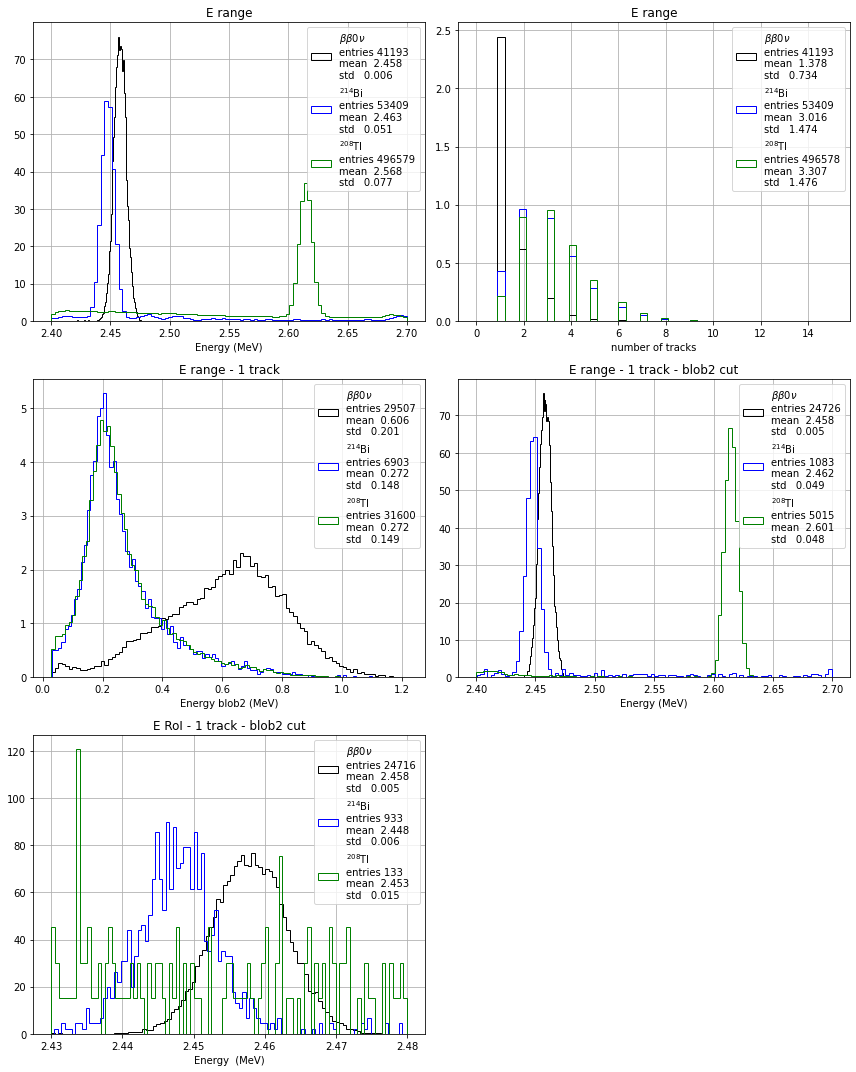

In [12]:
plt_fanal_mc(mcs, ssamples)

## Efficiencies

Compute and plot the efficiencies of the cuts: 

  * Energy in (2.4, 2.7) MeV
  
  * One track
  
  * Second blob Energy > 400 keV
  
  * Fine RoI (2.440, 2.475)

In [13]:
selnames  = ['E', 'num_tracks', 'blob2_E', 'E']
selranges = [erange, (1., 1.1), (eblob2, np.inf), eroi]

In [14]:
def selections(df, varnames, varranges):
    """ appy a list of selections in order in a data-frame
    inputs:
        df        : DataFrame
        varnames  : tuple(str), list of the variables of the selections
        varranges : tuple(float, float), range of the variables in the selection
    returns:
        sels: tuple(np.array(bool)), tuple with the selections applied in series
    """
    sel, sels =  None, []
    for i, varname in enumerate(varnames):
        isel = selection(df, varname, varranges[i])
        sel  = isel if sel is None else sel & isel
        sels.append(sel)
    return sels

def efficiency(sel, n = None):
    """ compute the efficiency and uncertanty of a selection
    inputs:
        sel: np.array(bool), bool array with True/False
        n  : int, denominator, if n is None, use len(sel)
    returns:
        eff : float, efficiency
        ueff: float, efficiency uncertainty
    """
    n    = n if n is not None else len(sel)
    eff  = np.sum(sel)/n
    ueff = np.sqrt(eff * (1- eff) / n)
    return eff, ueff

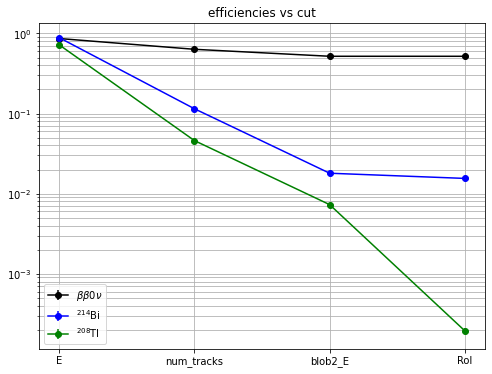

In [15]:
snames  = ['E', 'num_tracks', 'blob2_E', 'RoI']

subplot = pltext.canvas(1, 1, 6, 8)
subplot(1)
for i, mc in enumerate(mcs):
    sels = selections(mc, selnames, selranges)
    effs = [efficiency(sel) for sel in sels]
    veff = [eff[0] for eff in effs] # efficiencies values
    ueff = [eff[1] for eff in effs] # efficiencies uncertainties
    plt.errorbar(snames, veff, yerr = ueff, marker = 'o', label = ssamples[i])
plt.grid(which = 'both'); plt.yscale('log'); plt.legend();
plt.title('efficiencies vs cut');

In [16]:
for i, mc in enumerate(mcs):
    sels = selections(mc, selnames, selranges)
    effs = [efficiency(sel) for sel in sels]
    veff = [eff[0] for eff in effs] # efficiencies values
    ueff = [eff[1] for eff in effs] # efficiencies uncertainties
    print(tsamples[i], ': ', *[' {:s} eff {:6.5f}, '.format(s, eff) for s, eff in zip(selnames, veff)])

bb :   E eff 0.86475,   num_tracks eff 0.63433,   blob2_E eff 0.51906,   E eff 0.51885, 
Bi :   E eff 0.88743,   num_tracks eff 0.11493,   blob2_E eff 0.01799,   E eff 0.01550, 
Tl :   E eff 0.72251,   num_tracks eff 0.04602,   blob2_E eff 0.00730,   E eff 0.00019, 


## Estimate the energy resolution 

The energy resolution is a crucial parameters in this analysis.

Fit the energy distribution of the photo-peaks of Bi214, Tl208 and the bb0nu Qbb.

You can fit to a gaussian distribution or to a gaussian on top of a pedestal modeled with a straight line.

You can give the relative energy resolution as the sigma/E or FWHM/E.

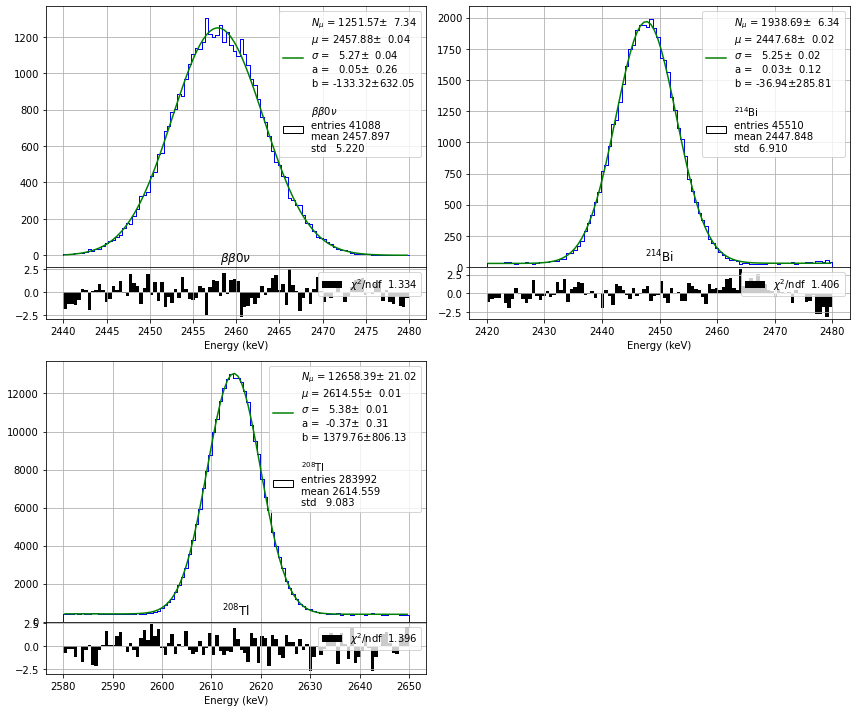

In [17]:
eranges = ((2440, 2480), (2420., 2480.), (2580, 2650))
fitfuns = ('gausline', 'gausline', 'gausline')
guesses =((50e3, 2458., 20., 0., 0.), (10e3, 2445., 20., 0., 300.), (50e3, 2615., 20., 0., 1.))

subplot = pltext.canvas(4)

resolutions = [] 
for i, mc in enumerate(mcs):
    subplot(i + 1)
    pltext.hist   (1e3 * mc.E, 100, range = eranges[i], label = ssamples[i]);
    pars, _, _, _ = pltext.hfitres(1e3 * mc.E, 100, range = eranges[i], fun = fitfuns[i], guess = guesses[i])
    resolutions.append((pars[2], pars[1])) # stores mu and sigma from the fit!
    plt.xlabel('Energy (keV)'); plt.title(ssamples[i])
plt.tight_layout();

In [18]:
for i, pars in enumerate(resolutions):
    sigma, fwhm = pars[0], 100 * 2.35 * pars[0]/pars[1]
    print('Energy resolution {:s}: sigma {:6.2f} KeV, {:6.2f} % FWHM'.format(tsamples[i], sigma, fwhm))

Energy resolution bb: sigma   5.27 KeV,   0.50 % FWHM
Energy resolution Bi: sigma   5.25 KeV,   0.50 % FWHM
Energy resolution Tl: sigma   5.38 KeV,   0.48 % FWHM
